# Week 4: Numerical Optimization

## Lecture 9 (Mon, Feb 1) Implementing Gradient Descent for Regression

Last time, we learned about the idea of gradient descent and the related mathematics (see the Lecture 8 notes in Canvas for details). Today, we will focus on implementing gradient descent using basic `NumPy`. Gradient descent is a general-purpose optimization algorithm, but we will start by using it for some regression problems using some methods we have developed in the class so far.

### Some Ideas from Multivariate Calculus

First, we need just a few ideas from multivariate calculus. This is quite minimal, but you learn more details about these topics in sections 4.3 (partial derivatives), 4.6 (gradients), and 4.7 (multivariate optimization) of <a href="https://openstax.org/details/books/calculus-volume-3">*Calculus Volume 3*</a> by Strang.

The ideas we need for gradient descent include:

* If we have a differentiable function of several variables, like our loss function $L(\theta) = L(\theta_0, ..., \theta_d)$, we can define the **partial derivatives** with respect to each of these variables as

    $$L_{\theta_i}=\frac{\partial L}{\partial \theta_i}=\lim\limits_{h\to 0}\frac{L(\theta+he_i) - L(\theta)}{h},$$

    where $e_i$ is a $(d+1)$-vector with all 0s except for a 1 in the $i$th component.  Geometrically, this partial derivative is the slope of $L$ if we go in the direction of $e_i$.
    
* To **minimize a multivariable function** by hand, we need to find critical points, which are points $\theta$ where *all* partial derivatives are 0 and compare which ones give the lowest outputs. In numerical algorithms, must settle for approximations that are "nearly" critical points.
    
* If we put these partial derivatives into a vector of $d+1$ variables, we call that a **gradient**, which we denote
    
    $$
    \nabla L(\theta)
    =\begin{pmatrix}
    L_{\theta_0}(\theta) \\
    \vdots \\
    L_{\theta_d}(\theta)
    \end{pmatrix}
    $$
    
* The **directional derivative** of a function in the direction of a unit vector $u$ starting from a point $\theta$.

$$D_u L(\theta) = \lim\limits_{h\to 0}\frac{L(\theta+hu) - L(\theta)}{h},$$
    
which is the slope in the direction of the vector $u$. Since $L$ is differentiable, this directional derivative will be defined for all directions leaving from $\theta$. In 1D, there are just two directions: left of right. In 2D, we have directional derivatives at every angle in a circle around the point.

* A common theorem says the **directional derivative is maximized in the direction of the gradient** at each point, so the gradient gives the direction of the *steepest ascent* in the function $L$. Similarly, the direction of the *steepest descent* is $-\nabla L(\theta)$, the opposite direction.

### The Geometry of Gradient Descent

We will discuss the geometry of gradient-based methods in class, but let's discuss a general outline of how gradient descent works, setting aside the stochastic version for now. The goal of gradient descent is to approximately solve the minimization problem

$$\min\limits_{\theta}\,L(\theta)$$

by finding (approximate) critical values by making a guess for the location of a critical value, taking a small step in the opposite direction as the gradient, and repeating this over and over until, hopefully, we reach a minimum value.

The steps are:

0. Make a guess for the critical value -- $\theta^0$
1. Compute the gradient of $L$ at $\theta^0$
2. Take a small step to $\theta^1 = \theta^0 - \alpha\nabla L\left(\theta^0\right)$
3. Compute the gradient of $L$ at $\theta^1$
4. Take a small step to $\theta^2 = \theta^1 - \alpha\nabla L\left(\theta^1\right)$
5. (repeat until the gradient gets close to $(0, ..., 0)$)

This $\alpha>0$ is a number that will be used in the algorithm as a multiplier of the steps the method will take. This is called the **learning rate**.

This idea seems plausible from the calculus ideas above because we just keep switching directions and making a step in the direction of the steepest downward path--the opposite direction as the gradient--until we reach a good place. This is a "greedy" algorithm because it just picks the quickest step in each iteration, which is fast, but it is likely to land in the first minimum it finds, which may or may not be optimal.

If you had two parameters, $L$ would be like a 3D curved surface. A nice visual to have in mind is a rain drop falling on a huge leaf. The droplet of water will move in the steepest downward direction due to gravity--but this direction *changes* as the drip follows the contours of the leaf. This is what gradient descent does.

Will the drip land in the physically lowest altitude part of the leaf? Maybe, but maybe not. If the rain drop lands on the edge, it will probably just roll off the edge. If the leaf has a few different "sinks," different initial locations of the rain drop might cause it to land in these different ones, some of which have lower altitudes than others. Now, if there is heavy rain and lots of rain drops land on the leaf, we can be pretty sure *some* of them will reach the lowest-altitude sink.

From this analogy, you might get the idea that we can make several initial guesses and run it to be more confident we will find the global minimum and not just a local minimum.

In the end, if some of our initial guesses are good choices, the step size $\alpha$ is not too big or too small, and the loss function is pretty well-behaved, the method will converge approximately to a local minimum.

### Implementing Gradient Descent

Let's import some libraries then write a function for gradient descent.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import scale

Gradient descent will need a few inputs:

* A function to minimize $f$
* A starting point $x_0$
* A learning rate $\alpha$
* A small number $h$ (the variable that goes to 0 in the definition of the derivative)
* A small positive value that we can use for a stopping condition for the derivative being sufficiently small (the tolerance)
* A maximum number of iterations

In [2]:
def computeGradient(f, x, h):
    # create a zero vector for the gradient
    n = len(x)
    gradient = np.zeros(n)
    
    # save f(x) so we don't need to compute it so frequently
    fx = f(x)
    
    # approximate the gradient
    for i in range(n):
        xUp = x.copy()
        
        # add h to the ith component of x
        xUp[i] += h
        
        # approximate the ith partial derivative
        gradient[i] = (f(xUp) - fx)/h
            
    return gradient

# run gradient descent and output the 
def gradientDescent(f, x0, alpha, h, tolerance, maxIterations):
    # set x equal to the initial guess
    x = x0
                
    # take up to maxIterations number of steps
    for counter in range(maxIterations):
        # update the gradient
        gradient = computeGradient(f, x, h)
        
        # stop if the norm of the gradient is near 0
        if np.linalg.norm(gradient) < tolerance:
            #print('Gradient descent took', counter, 'iterations to converge')
            #print('The norm of the gradient is', np.linalg.norm(gradient))
            # return the approximate critical value x
            return x
        
        # if we do not converge, print a message
        elif counter == maxIterations-1:
            #print("Gradient descent failed")
            #print('The gradient is', gradient)
            # return x, sometimes it is still pretty good
            return x
        
        # take a step in the opposite direction as the gradient
        x -= alpha*gradient

### OLS by Gradient Descent

Ideally, we want to use gradient descent for radial basis function expansions, for which we were unable to find an explicit formula for model parameters because the loss function does not have a unique solution, but let's start with a simpler problem: finding an approximate solution for the ordinary least squares problem.

Recall that, in this situation, we have some labeled datapoints $(x_{i1}, ..., x_{id}, y_i)$, where we fit a function of the form

$$f_\theta(x_i) = \theta_0 + \sum\limits_{j=1}^d\theta_jx_{ij}$$

To find the least squares solution, we aim to solve the minimization problem $\min\limits_\theta L(\theta)$ for $\theta=(\theta_0, \theta_1, ..., \theta_d)\in\mathbb{R}^{d+1}$, where the loss function is

$$L(\theta)=\sum\limits_{i=1}^n \left(y_i - f_\theta(x_i)\right)^2=\sum\limits_{i=1}^n \left(y_i - \theta_0 - \sum\limits_{j=1}^d\theta_jx_{ij}\right)^2$$

Let's bring in our exact OLS class for linear regression from Week 1.

In [3]:
class OrdinaryLeastSquaresExact:
        
    # fit the model to the data
    def fit(self, X, y):
        # save the training data
        self.data = np.hstack((np.ones([X.shape[0],1]), X))
        
        # save the training labels
        self.output = y
        
        # find the theta values that minimize the sum of squared errors
        X = self.data
        self.theta = np.linalg.inv(X.T @ X) @ X.T @ y
                
    # predict the output from input (testing) data
    def predict(self, X):
        # initialize an empty matrix to store the predicted outputs
        yPredicted = np.empty([X.shape[0],1])
        
        # append a column of ones at the beginning of X
        X = np.hstack((np.ones([X.shape[0],1]), X))
        
        # apply the function f with the values of theta from the fit function to each testing datapoint
        for row in range(X.shape[0]):
            yPredicted[row] = self.theta @ X[row,]
            
        return yPredicted

In addition, let's write an OLS class using gradient descent instead.

In [4]:
class OrdinaryLeastSquaresGradient:
        
    # fit the model to the data
    def fit(self, X, y, x0, alpha, h, tolerance, maxIterations):
        self.n = X.shape[0]
        self.d = X.shape[1]
        self.h = h
        self.alpha = alpha
        self.initialGuess = x0
        
        # save the training data
        self.data = np.hstack((np.ones([self.n, 1]), X))
        
        # save the training labels
        self.output = y
        
        # find the theta values that minimize the sum of squared errors via gradient descent
        X = self.data
        L = lambda theta: ((X @ theta).T - y.T) @ (X @ theta - y)
        self.theta = gradientDescent(L, self.initialGuess, self.alpha, self.h, tolerance, maxIterations)
                
    # predict the output from testing data
    def predict(self, X):
        # initialize an empty matrix to store the predicted outputs
        yPredicted = np.empty([X.shape[0],1])
        
        # append a column of ones at the beginning of X
        X = np.hstack((np.ones([X.shape[0],1]), X))
        
        # apply the function f with the values of theta from the fit function to each testing datapoint (rows of X)
        for row in range(X.shape[0]):
            yPredicted[row] = self.theta @ X[row,]
            
        return yPredicted

### 1D Example (Revisited)

FOR THE GRADIENT-BASED ORDINARY LEAST SQUARES CODE

The predicted y values are [1.88927362 2.39728623 2.90529883 3.41331144 2.39728623]
The real y values are [1 2 3 3 4]
The theta values are [-1.15880201  0.5080126 ]
The r^2 score is 0.2890134587732638
The mean absolute error is 0.6794572453892239 

FOR THE EXACT ORDINARY LEAST SQUARES CODE 

The predicted y values are [1.84615385 2.38461538 2.92307692 3.46153846 2.38461538]
The real y values are [1 2 3 3 4]
The theta values are [-1.38461538  0.53846154]
The r^2 score is 0.2899408284023671
The mean absolute error is 0.6769230769230786


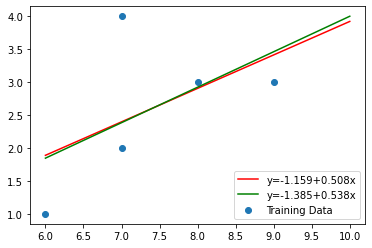

In [5]:
X = np.array([[6], [7], [8], [9], [7]])
y = np.array([1, 2, 3, 3, 4])

print('FOR THE GRADIENT-BASED ORDINARY LEAST SQUARES CODE')

# instantiate an OLS (gradient) object, fit to data, predict data
model = OrdinaryLeastSquaresGradient()
model.fit(X, y, [0, 0], alpha = 0.001, h = 0.001, tolerance = 0.01, maxIterations = 100000)
predictions = model.predict(X)

# print the predictions
print('\nThe predicted y values are', predictions.T[0])

# print the real y values
print('The real y values are', y)

# print the theta values
parameters = model.theta
print('The theta values are', parameters)

# plot the training points
plt.scatter(X, y, label = 'Training Data')

# plot the fitted model with the training data
xModel = np.linspace(6,10,100)
yModel = parameters[0] + parameters[1]*xModel
lineFormula = 'y={:.3f}+{:.3f}x'.format(parameters[0], parameters[1])
plt.plot(xModel, yModel, 'r', label = lineFormula)

# add a legend
plt.legend()

# return quality metrics
print('The r^2 score is', r2_score(y, predictions))
print('The mean absolute error is', mean_absolute_error(y, predictions),'\n')

###################################################################################

print('FOR THE EXACT ORDINARY LEAST SQUARES CODE \n')

# instantiate an OLS (exact) object, fit to data, predict data
model = OrdinaryLeastSquaresExact()
model.fit(X,y)
predictions = model.predict(X)

# print the predictions
print('The predicted y values are', predictions.T[0])

# print the real y values
print('The real y values are', y)

# print the theta values
parameters = model.theta
print('The theta values are', parameters)

# plot the fitted model with the training data
xModel = np.linspace(6,10,100)
yModel = parameters[0] + parameters[1]*xModel
lineFormula = 'y={:.3f}+{:.3f}x'.format(parameters[0], parameters[1])
plt.plot(xModel, yModel, 'g', label = lineFormula)

# add a legend
plt.legend()

# return quality metrics
print('The r^2 score is', r2_score(y, predictions))
print('The mean absolute error is', mean_absolute_error(y, predictions))

## 2D Example (Revisited)

In [6]:
trainX = np.array([[2, 2], [2, 3], [5, 6], [6, 7], [9, 10]])
trainY = np.array([3, 13, 19, 29, 35])

testX = np.array([[2, 1], [4, 5], [6, 5], [8, 9]])
testY = np.array([9, 15, 25, 31])

print('FOR THE GRADIENT-BASED ORDINARY LEAST SQUARES CODE \n')

# instantiate an OLS model
model = OrdinaryLeastSquaresGradient()

# fit the model to the training data (find the theta parameters)
model.fit(trainX, trainY, [0, 0, 0], alpha = 0.001, h = 0.001, tolerance = 0.01, maxIterations = 100000)

# return the predicted outputs for the datapoints in the training set
trainPredictions = model.predict(trainX)

# print the coefficient of determination r^2
print('The r^2 score is', r2_score(trainY, trainPredictions))

# print quality metrics
print('The mean absolute error on the training set is', mean_absolute_error(trainY, trainPredictions))

# return the predicted outputs for the datapoints in the test set
predictions = model.predict(testX)

# print the predictions
print('The predicted y values for the test set are', predictions.T[0])

# print the real y values
print('The real y values for the test set are', testY)

# print the theta values
thetaApprox = model.theta
print('The theta values are', thetaApprox)

# print quality metrics
print('The mean absolute error on the test set is', mean_absolute_error(testY, predictions), '\n')

##############################################################################################

print('FOR THE EXACT ORDINARY LEAST SQUARES CODE \n')

# instantiate an OLS model
model = OrdinaryLeastSquaresExact()

# fit the model to the training data (find the theta parameters)
model.fit(trainX, trainY)

# return the predicted outputs for the datapoints in the training set
trainPredictions = model.predict(trainX)

# print the coefficient of determination r^2
print('The r^2 score is', r2_score(trainY, trainPredictions))

# print quality metrics
print('The mean absolute error on the training set is', mean_absolute_error(trainY, trainPredictions))

# return the predicted outputs for the datapoints in the test set
predictions = model.predict(testX)

# print the predictions
print('The predicted y values for the test set are', predictions.T[0])

# print the real y values
print('The real y values for the test set are', testY)

# print the theta values
thetaExact = model.theta
print('The theta values are', thetaExact)

# print quality metrics
print('The mean absolute error on the test set is', mean_absolute_error(testY, predictions))

FOR THE GRADIENT-BASED ORDINARY LEAST SQUARES CODE 

The r^2 score is 0.9642661609185353
The mean absolute error on the training set is 1.543772079409448
The predicted y values for the test set are [-6.44748058 19.07004759  6.67858093 32.19610911]
The real y values for the test set are [ 9 15 25 31]
The theta values are [-3.53326263 -6.19573333  9.47724871]
The mean absolute error on the test set is 9.758764086772791 

FOR THE EXACT ORDINARY LEAST SQUARES CODE 

The r^2 score is 0.9642679900744419
The mean absolute error on the training set is 1.5359999999999538
The predicted y values for the test set are [-6.52 19.08  6.6  32.2 ]
The real y values for the test set are [ 9 15 25 31]
The theta values are [-3.56 -6.24  9.52]
The mean absolute error on the test set is 9.79999999999982


## Example: High School Graduate Rates in the US (Revisited)

In [7]:
# import the data from the csv file to an numpy array
data = pd.read_csv('data/US_State_Data.csv', sep=',').to_numpy()
#print(data)
X = np.array(data[:,1:8], dtype=float)
y = np.array(data[:,8], dtype=float)

# split the data into training and test sets
(trainX, testX, trainY, testY) = train_test_split(X, y, test_size = 0.25, random_state = 1)

# standardize the data
trainX = scale(trainX)
testX = scale(testX)

print('FOR THE GRADIENT-BASED ORDINARY LEAST SQUARES CODE')

# instantiate an OLS model
model = OrdinaryLeastSquaresGradient()

# fit the model to the training data (find the theta parameters)
model.fit(trainX, trainY, [0, 0, 0, 0, 0, 0, 0, 0], alpha = 0.001, h = 0.001, tolerance = 0.01, maxIterations = 100000)

# return the predicted outputs for the datapoints in the training set
trainPredictions = model.predict(trainX)

# print the coefficient of determination r^2
print('\nThe r^2 score is', r2_score(trainY, trainPredictions))

# print quality metrics
print('The mean absolute error on the training set is', mean_absolute_error(trainY, trainPredictions))

# return the predicted outputs for the datapoints in the test set
predictions = model.predict(testX)

# print the predictions
print('The predicted y values for the test set are', np.round(predictions.T[0],0))

# print the real y values
print('The real y values for the test set are     ', testY)

# print the theta values
print('The theta values are', model.theta)

# print quality metrics
print('The mean absolute error on the test set is', mean_absolute_error(testY, predictions), '\n')

##################################################################

print('FOR THE EXACT ORDINARY LEAST SQUARES CODE \n')

# instantiate an OLS model
model = OrdinaryLeastSquaresExact()

# fit the model to the training data (find the theta parameters)
model.fit(trainX, trainY)

# return the predicted outputs for the datapoints in the training set
trainPredictions = model.predict(trainX)

# print the coefficient of determination r^2
print('The r^2 score is', r2_score(trainY, trainPredictions))

# print quality metrics
print('The mean absolute error on the training set is', mean_absolute_error(trainY, trainPredictions))

# return the predicted outputs for the datapoints in the test set
predictions = model.predict(testX)

# print the predictions
print('The predicted y values for the test set are', np.round(predictions.T[0],0))

# print the real y values
print('The real y values for the test set are     ', testY)

# print the theta values
print('The theta values are', model.theta)

# print quality metrics
print('The mean absolute error on the test set is', mean_absolute_error(testY, predictions))

FOR THE GRADIENT-BASED ORDINARY LEAST SQUARES CODE

The r^2 score is 0.4035247529644912
The mean absolute error on the training set is 3.6674122809135246
The predicted y values for the test set are [82. 80. 89. 85. 81. 81. 85. 90. 78. 84. 83. 80. 83.]
The real y values for the test set are      [70. 83. 83. 81. 76. 87. 89. 89. 78. 78. 84. 80. 79.]
The theta values are [82.97247297 -3.76322781  0.79836794 -1.79592293 -1.16423823 -1.61290262
  2.114449    0.85703448]
The mean absolute error on the test set is 4.004933566373259 

FOR THE EXACT ORDINARY LEAST SQUARES CODE 

The r^2 score is 0.4035248263372673
The mean absolute error on the training set is 3.6671426682489647
The predicted y values for the test set are [82. 80. 89. 85. 81. 81. 85. 90. 78. 84. 83. 80. 83.]
The real y values for the test set are      [70. 83. 83. 81. 76. 87. 89. 89. 78. 78. 84. 80. 79.]
The theta values are [82.97297297 -3.76283254  0.79916919 -1.7971357  -1.16309073 -1.61151368
  2.11474925  0.85811261]
The m

## Comments on Gradient Descent

* We get almost identical results in all of these examples in using a gradient-based method for ordinary least squares.

* It runs a little slower, but not much.

* We must be careful with the $h$ and tolerance hyperparameters to be sure gradient descent will converge.

* Gradient descent in our implementation above does not actually require any derivatives since we only used approximate derivatives.

* If we knew formulas for the derivatives, we could compute them exactly to let the step size be exactly proportional to $\nabla L$. This would drastically reduce the number of times we compute the loss function.

* Gradient descent and related methods are the main driver of many machine learning problems that are based on to minimizing a loss function (least squares and neural networks, among others), although we will later need some variants to reduce the computational burden.

### Gradient Descent for Kernel Regression/Smoothing

Kernel smoothing also worked by creating a 

In [8]:
def GaussianKernel(x0, x, lam):
    return (1/lam) * np.exp(-np.linalg.norm(x0 - x) ** 2 / (2 * lam ** 2))

class KernelRegressionGradient:
    def __init__(self, kernel_function, lam, fit_intercept = True):
        self.kernel_function = kernel_function
        self.fit_intercept = fit_intercept
        self.lam = lam

    def predict(self, x0, X, y, theta0, alpha, h, tolerance, maxIterations):
        # find the number of X points
        n = X.shape[0]

        # add a column of ones if needed
        if self.fit_intercept:
            X = np.hstack((np.ones([n,1]), X))

        # construct the kernel matrix
        kernel = np.zeros([n, n])

        # populate the kernel matrix
        for i in range(n):
            kernel[i][i] = self.kernel_function(x0, X[i,:], self.lam)

        L = lambda theta: (X @ theta - y).T @ kernel @ (X @ theta - y)
        self.theta = gradientDescent(L, theta0, alpha, h, tolerance, maxIterations)

        return np.array([1, np.float(x0)]) @ self.theta

In [9]:
# read the shampoo sales dataset
data = pd.read_csv('data/shampoo.csv')

# save the targets
y = data['Sales'].to_numpy()

# make a column vector of 0s with n elements
X = np.zeros([y.shape[0], 1])

# convert the vector to (0, 1, 2, ..., n)
X[:,0] = [i for i in range(y.shape[0])]

X = scale(X)

# split the data into train and test sets
(trainX, testX, trainY, testY) = train_test_split(X, y, test_size = 0.25, random_state = 1)

lambda: 1 		r^2: 0.781 		train MAE: 54.857 		test MAE: 40.303


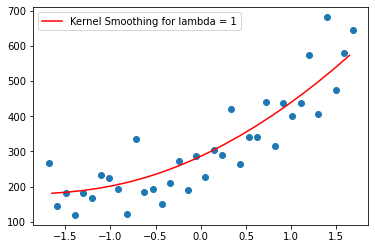

In [10]:
lam = 1

model = KernelRegressionGradient(GaussianKernel, lam)

# compute the model coordinates
xModel = scale([i for i in range(20)])
yModel = [model.predict(i, trainX, trainY, [0, 0], alpha = 0.001, h = 0.0001, tolerance = 0.01, maxIterations = 100000) for i in xModel]

# plot the model
label = 'Kernel Smoothing for lambda = ' + str(np.round(lam, 2))
plt.scatter(X, y)
plt.plot(xModel, yModel, 'r', label = label)
plt.legend()
    
# apply the functions to the test data and predict with the model
trainPredictions = [model.predict(i, trainX, trainY, [0, 0], alpha = 0.001, h = 0.0001, tolerance = 0.01, maxIterations = 100000) for i in trainX]
testPredictions = [model.predict(i, trainX, trainY, [0, 0], alpha = 0.001, h = 0.0001, tolerance = 0.01, maxIterations = 100000) for i in testX]
    
# compute the training and test mean absolute error
trainError = mean_absolute_error(trainY, trainPredictions)
testError = mean_absolute_error(testY, testPredictions)
    
# return quality metrics
print('lambda:', np.round(lam, 3), '\t\tr^2:', np.round(r2_score(trainY, trainPredictions), 3),
      '\t\ttrain MAE:', np.round(trainError, 3), '\t\ttest MAE:', np.round(testError, 3))

We could run it like last time (below), but it becomes **very** expensive.

0
lambda: 0.6 		r^2: 0.739 		train MAE: 56.185 		test MAE: 44.689
1
lambda: 0.7 		r^2: 0.801 		train MAE: 52.886 		test MAE: 43.425
2
lambda: 0.8 		r^2: 0.8 		train MAE: 52.851 		test MAE: 41.338
3
lambda: 0.9 		r^2: 0.789 		train MAE: 54.078 		test MAE: 40.68
4
lambda: 1.0 		r^2: 0.781 		train MAE: 54.857 		test MAE: 40.303
5


KeyboardInterrupt: 

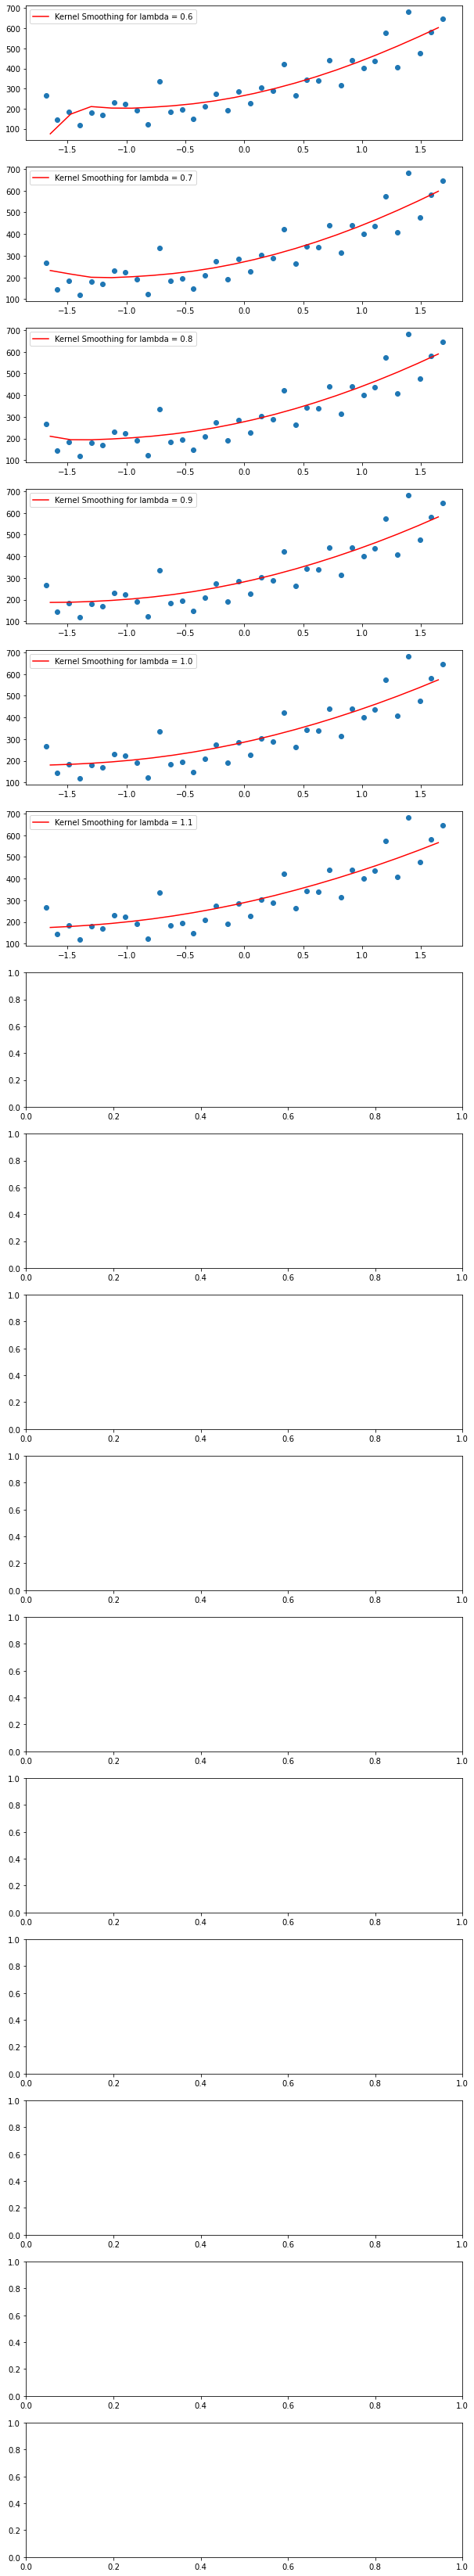

In [11]:
lamValues = np.linspace(0.6, 2, 15)

M = lamValues.shape[0]

# allow multiple plots
fig, axes = plt.subplots(nrows = M + 1, figsize = (10, 4*M))

trainMAE = []
testMAE = []

for (j, lam) in enumerate(lamValues):
    print(j)
    model = KernelRegressionGradient(GaussianKernel, lam)

    # compute the model coordinates
    xModel = scale([i for i in range(20)])
    yModel = [model.predict(i, trainX, trainY, [0, 0], alpha = 0.001, h = 0.0001, tolerance = 0.01,
                            maxIterations = 100000) for i in xModel]

    # plot the model
    label = 'Kernel Smoothing for lambda = ' + str(np.round(lam, 2))
    axes[j].scatter(X, y)
    axes[j].plot(xModel, yModel, 'r', label = label)
    axes[j].legend()
    
    # apply the functions to the test data and predict with the model
    trainPredictions = [model.predict(i, trainX, trainY, [0, 0], alpha = 0.001, h = 0.0001,
                                      tolerance = 0.01, maxIterations = 100000) for i in trainX]
    testPredictions = [model.predict(i, trainX, trainY, [0, 0], alpha = 0.001, h = 0.0001,
                                     tolerance = 0.01, maxIterations = 100000) for i in testX]
    
    # compute the training and test mean absolute error
    trainError = mean_absolute_error(trainY, trainPredictions)
    testError = mean_absolute_error(testY, testPredictions)
    
    # save the training and test mean absolute error
    trainMAE.append(trainError)
    testMAE.append(testError)

    # return quality metrics
    print('lambda:', np.round(lam, 3), '\t\tr^2:', np.round(r2_score(trainY, trainPredictions), 3),
          '\t\ttrain MAE:', np.round(trainError, 3), '\t\ttest MAE:', np.round(testError, 3))
    
# plot the errors
axes[M].plot(range(M), trainMAE, label = 'Training Mean Absolute Error')
axes[M].plot(range(M), testMAE, label = 'Testing Mean Absolute Error')
axes[M].legend()

## Lecture 10 (Wed, Feb 3) Radial Basis Functions, A Closed-Form Gradient

Last week, we saw that radial basis function networks model unknown functions as

$$\hat{f}(x_i)=\theta_0 + \sum\limits_{j=1}^M K_{\lambda_j}(\xi_j,x_i)\theta_j=X_K\theta$$

where $K$ is some function dependent on the distance between points $\xi_j$ and $x$, but is not otherwise dependent on those variables. The most common is the Gaussian kernel,

$$K_{\lambda_j}(\xi_j,x_i) = \exp\left(-\frac{\|\xi_j-x_i\|^2}{2\lambda_j^2}\right)$$

and

$$X_K=\begin{pmatrix}
1 & K_{\lambda_1}(\xi_1, x_1) & \cdots & K_{\lambda_M}(\xi_M, x_1)\\
1 & K_{\lambda_1}(\xi_1, x_2) & \cdots & K_{\lambda_M}(\xi_M, x_2)\\
\vdots & \vdots & \ddots & \vdots\\
1 & K_{\lambda_1}(\xi_1, x_n) & \cdots & K_{\lambda_M}(\xi_M, x_n)
\end{pmatrix}$$

and $\theta=(\theta_0, \theta_1, ..., \theta_M)$.

We will try to fit the model to the training data $(x_1,y_1), (x_2, y_2), ..., (x_n, y_n)$, where each point is in $d$-dimensional space: $x_i\in\mathbb{R}^d$. The parameter has parameters $\lambda_j$, $\theta_j$, $\xi_j$ for $j=1, 2, ..., M$ and $\theta_0$, noting each $\xi_j$ has the same dimension as each $x_i$.

A good approach to Fitting the model is to minimize the sum of squared error loss function,

$$L(\theta,\lambda,\xi)=\|X_K\theta - y\|^2$$

where $y=(y_1, y_2, ..., y_n)$ That is, to solve the problem

$$\min\limits_{\theta, \lambda, \xi}L(\theta,\lambda,\xi)$$

It turns out, this problem is not particularly easy for a few reasons:

* $L$ is non-convex and does not have a unique minimum. There are local minima, so it is difficult to know if we have found the global minimum.
* $L$ depends on $M+1$ variables $\theta_j$, $M$ variables $\lambda_j$, and $M$ $d$-dimensional variables $\xi_j$, which makes many variables with respect to which we need to minimize.

Unlike the previous methods we have learned, finding critical values of the loss function $L$ is not easy enough to do by hand, so we will rely on algorithms like gradient descent for this purpose.

In addition, approximating gradients $\nabla L$ with the `computeGradient` function will be incredibly expensive since we would need to evaluate $L$ with a small perturbation in each of the $(2+d)M+1$ components of the input to $L$ to get all the partial derivatives in *each* iteration of gradient descent.

This is infeasible, so we will derive a closed-form formula for the exact gradient $\nabla L$ that can be implemented instead of requiring all of these evaluations of $L$. Please see the details in the lecture video, but we found the following partial derivatives.

$$\begin{align}
&\frac{\partial L(\theta,\lambda,\xi)}{\partial \theta_0}=2\sum\limits_{i=1}^n\left(\hat{f}(x_i)-y_i\right)\\
&\frac{\partial L(\theta,\lambda,\xi)}{\partial \theta_k}=2\sum\limits_{i=1}^n\left(\hat{f}(x_i)-y_i\right)K_{\lambda_k}(\xi_k,x_i), &&k=1, 2, ..., M\\
&\frac{\partial L(\theta,\lambda,\xi)}{\partial \theta_k}=2\frac{\theta_k}{\lambda_k}\sum\limits_{i=1}^n\left(\hat{f}(x_i)-y_i\right)K_{\lambda_k}(\xi_k,x_i)\left(\frac{\|\xi_k-x_i\|^2}{\lambda_k^2}-1\right), &&k=1, 2, ..., M\\
&\frac{\partial L(\theta,\lambda,\xi)}{\partial \xi_{kl}}=2\frac{\theta_k}{\lambda_k^2}\sum\limits_{i=1}^n\left(\hat{f}(x_i)-y_i\right)K_{\lambda_k}(\xi_k,x_i)(x_{il}-\xi_{kl}), &&k=1, 2, ..., M\text{ and }l=1, ..., d
\end{align}
$$

Note that the derivatives all have the $(\hat{f}(x_i)-y_i)$ term and some share the $K_{\lambda_k}(\xi_k,x_i)$ term, so an effective implementation that computes these partial derivatives will reuse the calculations rather than redoing them so many times.

It should be noted the coefficient 2 of each of these may be dropped because we will be taking steps proportional to the gradient $\nabla L$ with a learning rate we can control, so it is redundant and we omit it from the code.

## Lecture 11 (Fri, Feb 5) Implementing Gaussian RBF Networks

In [598]:
# create a RBF network class
class GaussianRBFnetwork:
    # initialize the model
    def __init__(self, d, M, alpha = 0.001, initialization = 'uniform'):
        # the dimension of the datapoints
        self.d = d
        
        # the number of radial basis functions
        self.M = M
                
        # the learning rate
        self.alpha = alpha
        
        # initialize the parameters
        if initialization == 'uniform':
            theta = 10 * np.random.uniform(-1, 1, size = (M + 1))
            lam = 10 * np.random.uniform(0, 1, size = (M))
            xi = 10 * np.random.uniform(-1, 1, size = (M, d))
            #print(theta)
            #print(lam)
            #print(xi)

        # save the initial parameters
        self.theta = theta
        self.lam = lam
        self.xi = xi
                
    # fit the model to some data X with labels y
    def fit(self, X, y, epochs = 1000, update = 10):
        self.n = X.shape[0]
        
        # save the training data
        self.input = np.hstack((np.ones([self.n, 1]), X))
        
        # save the training labels
        self.output = y
        
        # initialize the kernel-weighted inputs
        XK = np.zeros([self.n, self.M])
        XK = np.hstack((np.ones([self.n, 1]), XK))
        
        # save the learning rate locally
        alpha = self.alpha
        
        # run gradient descent with exact gradient
        # pre-compute terms
        for j in range(epochs):
            # compute the kernel-weighted inputs
            for i in range(self.n):
                for k in range(self.M):
                    XK[i, k + 1] = self.GaussianKernel(self.input[i, 1:], self.xi[k], self.lam[k])
                        
            # training predictions
            predictions = XK @ self.theta
            
            # compute the error
            error = predictions - self.output

            # compute theweighted error
            weightederror = np.atleast_2d(error).T * XK
            
            # compute the theta partial derivatives
            thetagrad = np.sum(weightedError, axis = 0)
            
            # compute the lambda partial derivatives
            term3 = np.zeros([self.n, self.M])
            for k in range(self.M):
                term3[:, k] = ((np.linalg.norm(self.xi[k] - self.input[:,1:], axis = 1)/self.lam[k]) ** 2 - 1) * self.theta[k]/self.lam[k]
            
            lamerror = term3 * weightederror[:, 1:]
            lamgrad = np.sum(lamerror, axis = 0)

            # compute the xi partial derivatives
            term4 = np.zeros([self.n, self.M, self.d])
            for k in range(self.M):
                for l in range(self.d):
                    term4[:, k, l] = (self.input[:, l] - self.xi[k, l]) * self.theta[k] / self.lam[k] ** 2

            xierror = term4 * np.atleast_3d(weightederror[:, 1:])
            xigrad = np.sum(xierror, axis = 0)
            
            # weight update
            self.theta -= self.alpha * thetagrad
            self.lam -= self.alpha * lamgrad
            self.xi -= self.alpha * xigrad
            
            if j % update == 0:
                print('Epoch', j, '\tLoss =', np.sum(error ** 2)/self.M)
                self.alpha = (1 - j / epochs) * alpha

    # fit the model to some data X
    def predict(self, X):
        # compute predictions
        n = X.shape[0]
        
        # initialize the kernel-weighted inputs
        XK = np.zeros([n, self.M])
        XK = np.hstack((np.ones([n, 1]), XK))
        
        # compute the kernel-weighted inputs
        for i in range(n):
            for k in range(self.M):
                XK[i, k + 1] = self.GaussianKernel(X[i, 1:], self.xi[k], self.lam[k])
                
        # training predictions
        predictions = XK @ self.theta

        return predictions
        
    def GaussianKernel(self, x, xi, lam):
        return (1/lam) * np.exp(-np.linalg.norm(x - xi) ** 2 / (2 * lam ** 2))

Epoch 0 	Loss = 2.4650367679389653
Epoch 10000 	Loss = 6.488489740491751
Epoch 20000 	Loss = 15.327592459134308
Epoch 30000 	Loss = 27.225978082901054
Epoch 40000 	Loss = 40.65454076105925
Epoch 50000 	Loss = 54.33379738303548
Epoch 60000 	Loss = 67.21835733317181
Epoch 70000 	Loss = 78.47334744986459
Epoch 80000 	Loss = 87.45488365849391
Epoch 90000 	Loss = 93.69508627290605
The r^2 score is -42.519492330032975
The mean absolute error on the training set is 8.132738315806344


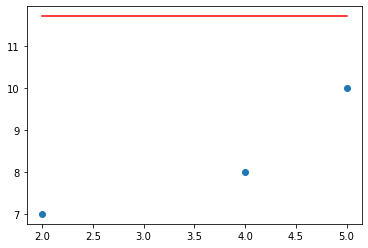

In [600]:
model = GaussianRBFnetwork(d = 1, M = 2, alpha = 0.00001)

Xt = np.array([[2], [4], [5]])
yt = np.array([7, 8, 10])

model.fit(Xt, yt, epochs = 100000, update = 10000)

# predict the outputs
predictions = model.predict(Xt)

# plot the training points
plt.scatter(Xt, yt, label = 'Training Data')

# compute the training and test mean absolute error
trainError = mean_absolute_error(yt, predictions)

# return quality metrics
print('The r^2 score is', r2_score(yt, predictions))
print('The mean absolute error on the training set is', trainError)

# plot the fitted model with the training data
#xModel = np.atleast_2d(np.linspace(Xt[0][0],Xt[-1][0],100)).T

# compute the predicted curve
#yModel = model.predict(xModel)

#print(yModel)

plt.plot(xModel, yModel, 'r')

In [584]:
# read the shampoo sales dataset
data = pd.read_csv('data/shampoo.csv')

# save the targets
y = data['Sales'].to_numpy()

# make a column vector of 0s with n elements
X = np.zeros([y.shape[0], 1])

# convert the vector to (0, 1, 2, ..., n)
X[:,0] = [i for i in range(y.shape[0])]

#X = scale(X)

# split the data into train and test sets
trainX, testX, trainY, testY = train_test_split(X, y, test_size = 0.25, random_state = 1)

Epoch 0 	Loss = 2741107.3857147153
Epoch 1000 	Loss = 2547898.3554611234
Epoch 2000 	Loss = 2379738.568447751
Epoch 3000 	Loss = 2238395.1786864353
Epoch 4000 	Loss = 2119402.865553609
Epoch 5000 	Loss = 2020883.275885965
Epoch 6000 	Loss = 1941230.848705536
Epoch 7000 	Loss = 1879108.8658256184
Epoch 8000 	Loss = 1833448.5215574792
Epoch 9000 	Loss = 1803448.4944784634
[[94.99664498]
 [ 1.        ]] [-13.21458969  17.04519742]
[[94.99664498]
 [ 1.        ]] [-13.21458969  17.04519742]
[72.1770246 72.1770246 72.1770246 72.1770246 72.1770246 72.1770246
 72.1770246 72.1770246 72.1770246 72.1770246 72.1770246 72.1770246
 72.1770246 72.1770246 72.1770246 72.1770246 72.1770246 72.1770246
 72.1770246 72.1770246 72.1770246 72.1770246 72.1770246 72.1770246
 72.1770246 72.1770246 72.1770246 72.1770246 72.1770246 72.1770246
 72.1770246 72.1770246 72.1770246 72.1770246 72.1770246 72.1770246
 72.1770246 72.1770246 72.1770246 72.1770246 72.1770246 72.1770246
 72.1770246 72.1770246 72.1770246 72.177

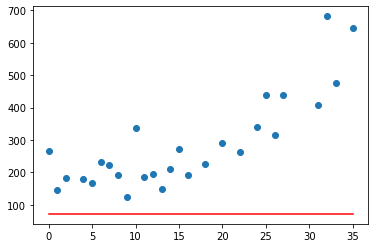

In [585]:
model = GaussianRBFnetwork(d = 1, M = 2, alpha = 0.001)

model.fit(trainX, trainY, epochs = 10000, update = 1000)

# predict the outputs
trainPredictions = model.predict(trainX)

# plot the training points
plt.scatter(trainX, trainY, label = 'Training Data')

# plot the fitted model with the training data
xModel = np.atleast_2d(np.linspace(X[0][0],X[-1][0],100)).T
    
# compute the predicted curve
yModel = model.predict(xModel)
print(yModel)

plt.plot(xModel, yModel, 'r')

testPredictions = model.predict(testX)

# compute the training and test mean absolute error
trainError = mean_absolute_error(trainY, trainPredictions)
testError = mean_absolute_error(testY, testPredictions)
    
# return quality metrics
print('The r^2 score is', r2_score(trainY, trainPredictions))
print('The mean absolute error on the training set is', trainError)
print('The mean absolute error on the testing set is', testError)